### Importing Essential Libraries
- Pandas (pd)
- NumPy (np)
- MatPlotLib (plt)
- Seaborn (sns)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("amazon_products_data.csv")
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2222742 entries, 0 to 2222741
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   asin               object 
 1   title              object 
 2   imgUrl             object 
 3   productURL         object 
 4   stars              float64
 5   reviews            int64  
 6   price              float64
 7   isBestSeller       bool   
 8   boughtInLastMonth  int64  
 9   categoryName       object 
dtypes: bool(1), float64(2), int64(2), object(5)
memory usage: 1.1 GB


### 1. Data Cleaning
- Count rows before cleaning
- Delete the products with missing data from the database
- Delete outliers
- Delete any duplicated products
- Count rows after cleaning

In [4]:
len(df)

2222742

In [5]:
df.dropna(subset=["categoryName", "title", "productURL", "isBestSeller", "boughtInLastMonth", "asin"], inplace=True, ignore_index=True)

In [6]:
category_stats = (df
                    .groupby(["categoryName"], as_index=False, observed=True)
                    .agg(avg_price= ("price", "mean"), std_price= ("price", "std"))
)
standardized_prices = df.merge(category_stats, on="categoryName", how="left")
standardized_prices = (standardized_prices
    .assign(
        zscore= ((standardized_prices["price"] - standardized_prices["avg_price"])
                / (standardized_prices["std_price"]))
    ).drop(columns= ["title", "imgUrl", "productURL", "stars", "reviews", "isBestSeller", "boughtInLastMonth"])
)
df = df.loc[standardized_prices["zscore"].abs() < 3, :].reset_index().drop(columns="index")

In [7]:
df.drop_duplicates(subset=["asin"], ignore_index=True, inplace=True)

In [8]:
len(df)

2187861

### 2. Memory Optimization

In [9]:
(df.memory_usage(deep=True).sum() / (1024**2)).round(2)

np.float64(1106.14)

In [10]:
new_dt = {
    "asin": "string",
    "title": "string",
    "imgUrl": "string",
    "productURL": "string",
    "stars": "float64",
    "reviews": "int32",
    "price": "float64",
    "isBestSeller": "bool",
    "boughtInLastMonth": "int32",
    "categoryName": "category"
}
df = df.astype(new_dt)

In [11]:
img_url_start = "https://m.media-amazon.com/images/I"
product_url_start = "https://www.amazon.co.uk/dp"
df['imgUrl'] = df['imgUrl'].str[len(img_url_start):]
df['productURL'] = df['productURL'].str[len(img_url_start):]
df.head()

,asin,title,imgUrl,productURL,stars,reviews,price,isBestSeller,boughtInLastMonth,categoryName
0,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",/71C3lbbeLsL._AC_UL320_.jpg,G33,4.7,15308,21.99,False,0,Hi-Fi Speakers
1,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",/61c5rSxwP0L._AC_UL320_.jpg,C8S,4.7,98099,23.99,True,0,Hi-Fi Speakers
2,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",/61j3SEUjMJL._AC_UL320_.jpg,XDF,4.7,15308,21.99,False,0,Hi-Fi Speakers
3,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",/71yf6yTNWSL._AC_UL320_.jpg,VGV,4.7,7205,31.99,False,0,Hi-Fi Speakers
4,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,/613dEoF9-rL._AC_UL320_.jpg,D65,4.6,1881,17.99,False,0,Hi-Fi Speakers


In [12]:

(df.memory_usage(deep=True).sum() / (1024**2)).round(2)

np.float64(806.42)

### 3. EDA
- Average & Median:
    * Price
    * Reviews
    * Stars
    * Bought In Last Month
- Category Analysis:
    * Ranking Categories By Total Sales In Last Month
    * Explore Price Range Within Each Category
    * Stars Rating Distribution By Category
- Reviews Analysis:
    * Ranking Products Based On Review Count
    * Categorizing Porducts Based On Star Count
    * Look For Correlation Between Prices And Stars, and Prices And Reviews
- Best Sellers Analysis:
    * Top 10 Best Sellers

In [13]:
avg_median = (pd
                .DataFrame()
                .assign(
                        average= (df[["price", "reviews", "stars", "boughtInLastMonth"]]
                                .mean()
                                .sort_values(ascending=False)),
                        median= (df[["price", "reviews", "stars", "boughtInLastMonth"]]
                                .median()
                                .sort_values(ascending=False))
                ))

avg_median.index = ['Reviews', 'Price', 'Bought In Last Month', 'Stars']

avg_median

,average,median
Reviews,384.124455,0.00
Price,69.459122,19.31
Bought In Last Month,18.756539,0.00
Stars,2.038410,0.00


<Axes: xlabel='Variable', ylabel='Median'>

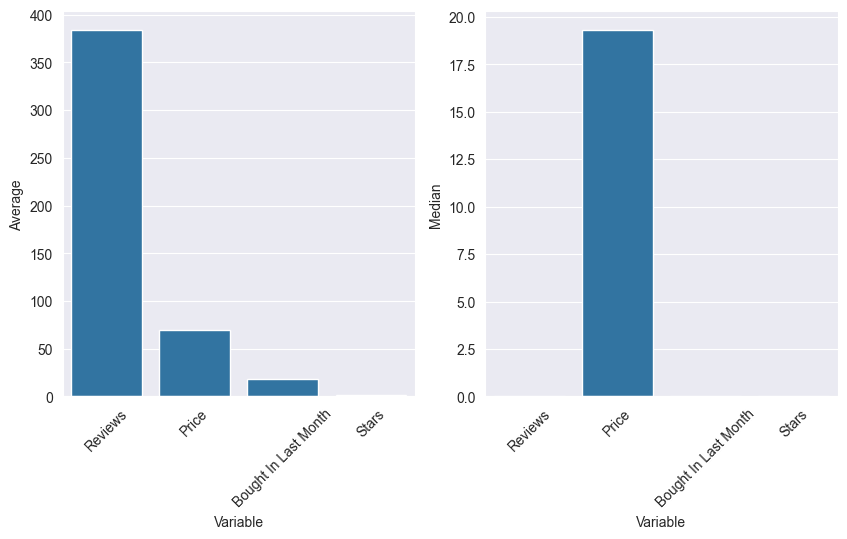

In [14]:
sns.set_style('darkgrid')

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax1.set_xlabel('Variable')
ax1.set_ylabel('Average')
ax1.tick_params(axis='x', labelrotation=45)

ax2.set_xlabel('Variable')
ax2.set_ylabel('Median')
ax2.tick_params(axis='x', labelrotation=45)

sns.barplot(data=avg_median, x=avg_median.index, y='average', ax=ax1)
sns.barplot(data=avg_median, x=avg_median.index, y='median', ax=ax2)

In [15]:
category_bought_last_month = (df
    .groupby(
        "categoryName", 
        as_index=False, 
        observed=False
    )["boughtInLastMonth"].sum()
    .sort_values(
        "boughtInLastMonth", 
        ascending=False, 
        ignore_index=True
    )
)
category_bought_last_month.columns = ['Category Name', 'Bought In Last Month']
category_bought_last_month.head()

,Category Name,Bought In Last Month
0,Health & Personal Care,8201050
1,Grocery,4291050
2,Pet Supplies,3216450
3,Skin Care,2091050
4,Storage & Organisation,1780650


In [16]:
(df
    .groupby(
        "categoryName",
        as_index=False,
        observed=False
    ).agg(
        minPrice= ("price", "min"),
        maxPrice= ("price", "max"),
        avgPrice= ("price", "mean"),
        medianPrice= ("price", "median"),
    ).sort_values(
        "categoryName",
        ascending=True,
        ignore_index=True
    )
)

,categoryName,minPrice,maxPrice,avgPrice,medianPrice
0,3D Printers,5.99,6027.26,661.849030,299.000
1,3D Printing & Scanning,1.94,799.00,69.516011,35.770
2,Abrasive & Finishing Products,2.25,65.23,14.136707,10.145
3,Action Cameras,3.19,848.16,140.244884,88.500
4,Adapters,1.99,25.99,8.086518,6.990
...,...,...,...,...,...
291,Wind Instruments,3.00,2709.72,307.525796,115.990
292,Window Treatments,3.99,55.99,19.249444,17.990
293,Women,1.54,83.81,19.574915,15.990
294,Women's Sports & Outdoor Shoes,3.20,226.00,70.560057,60.960


In [17]:
(df
    .assign(
        counter= 1
    ).groupby(
        "categoryName",
        as_index=False,
        observed=False
    ).agg(
        avgStars= ("stars", "mean"),
        totalProducts= ("counter", "sum")
    ).sort_values(
        "categoryName",
        ascending=True,
        ignore_index=True
    )
)

,categoryName,avgStars,totalProducts
0,3D Printers,2.765823,237
1,3D Printing & Scanning,0.104009,3941
2,Abrasive & Finishing Products,4.136179,246
3,Action Cameras,0.957114,991
4,Adapters,4.136032,247
...,...,...,...
291,Wind Instruments,2.067755,245
292,Window Treatments,4.102564,234
293,Women,4.154792,15871
294,Women's Sports & Outdoor Shoes,3.944513,1932


In [18]:
df.loc[:, ["asin", "reviews"]].sort_values("reviews", ascending=False, ignore_index=True)

,asin,reviews
0,B07KWYGTC6,1356658
1,B00NTCHCU2,1356658
2,B00LH3DMUO,1356658
3,B00O869QUC,1356658
4,B00MNV8E0C,1356658
...,...,...
2187856,B0CCVQZXH9,0
2187857,B0CCVQZXF3,0
2187858,B0CCVQZPT7,0
2187859,B0CCVQYX2K,0


In [19]:
conds = [
    ((df["stars"] >= 0) & (df["stars"] <= 1)),
    ((df["stars"] > 1) & (df["stars"] <= 2)),
    ((df["stars"] > 2) & (df["stars"] <= 3)),
    ((df["stars"] > 3) & (df["stars"] <= 4)),
    ((df["stars"] > 4) & (df["stars"] <= 5)),
]
vals = ["0 -> 1 Stars", "1 -> 2 Stars", "2 -> 3 Stars", "3 -> 4 Stars", "4 -> 5 Stars"]
stars_categorization = (df
                        .loc[:, ["asin", "stars"]]
                        .assign(starsCategories= np.select(conds, vals, "None"))
                        .groupby("starsCategories", as_index=False)
                        .agg(count= ("asin", "count"))
)
stars_categorization

,starsCategories,count
0,0 -> 1 Stars,1160177
1,1 -> 2 Stars,4973
2,2 -> 3 Stars,24573
3,3 -> 4 Stars,186699
4,4 -> 5 Stars,811439


<Axes: xlabel='starsCategories', ylabel='count'>

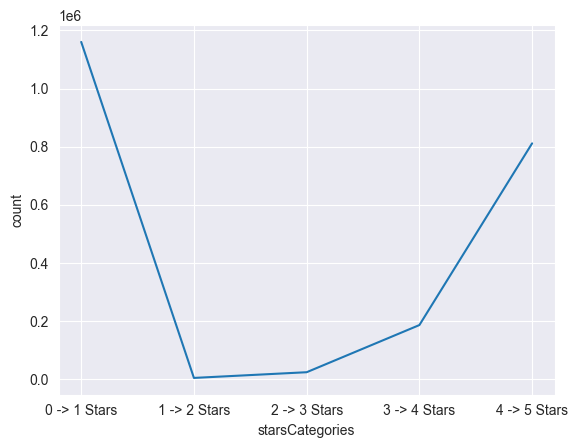

In [20]:
sns.lineplot(data=stars_categorization, x='starsCategories', y='count')

In [21]:
df.loc[:, ["price", "reviews", "stars"]].corr().drop(columns=["reviews", "stars"]).drop(labels="price").rename(columns={"price": "correlationBetweenPriceAnd"})

,correlationBetweenPriceAnd
reviews,-0.015317
stars,-0.141480


In [22]:
(df[df["isBestSeller"]]
    .sort_values(
        ["boughtInLastMonth", "reviews", "stars", "asin"],
        ascending=[False, False, False, True],
        ignore_index=True
    ).loc[:, ["asin", "boughtInLastMonth"]].head(10)
)

,asin,boughtInLastMonth
0,B01JS6YLQK,30000
1,B00BSYR7K8,20000
2,B001ETUD5I,20000
3,B006ZMNWYS,20000
4,B086KDW3W5,20000
5,B0080ZSQKS,20000
6,B004RDYI04,20000
7,B00IIOR7NS,20000
8,B01CJXO4LQ,20000
9,B0BH8SHD38,20000


### 4. Customer Behavior
- Most popular products
- Customer preferences across categories
- Segment products by target audience

In [23]:
(df
 .sort_values(
     ["reviews", "stars"],
     ascending=False,
     ignore_index=True
 ).reset_index()
 .assign(
     rank= lambda x: x["index"] + 1
 ).drop(columns=["index"])
 .set_index("rank")
 .loc[:50, ["asin", "title", "reviews", "stars"]]
)

,asin,title,reviews,stars
rank,,,,
1,B07KX2N355,"Amazon Basics AAA Alkaline Batteries, High-Per...",1356658,4.6
2,B00NTCH52W,Amazon Basics AA 1.5 Volt Performance Alkaline...,1356658,4.6
3,B07KWYGTC6,Amazon Basics AA Performance Alkaline Batterie...,1356658,4.6
4,B00NTCHCU2,Amazon Basics AAA 1.5 Volt Performance Alkalin...,1356658,4.6
5,B00MNV8E0C,Amazon Basics AA 1.5 Volt Performance Alkaline...,1356658,4.6
6,B01B8R6V2E,Amazon Basics AAA 1.5 Volt Performance Alkalin...,1356658,4.6
7,B00LH3DMUO,Amazon Basics AAA 1.5 Volt Performance Alkalin...,1356658,4.6
8,B00O869QUC,Amazon Basics AAA 1.5 Volt Performance Alkalin...,1356658,4.6
9,B094D5Y9WS,Amazon Basics 10-Pack AA High-Performance Alka...,1356658,4.6


In [24]:
agg_categories = (df
                    .groupby(["categoryName"], as_index=False)
                    .agg({'stars': 'mean', 'reviews': 'sum'})
                    .assign(
                        reviewsDist= lambda x: (x["reviews"] / x["reviews"].sum() * 100).round(2),
                        stars= lambda x: x["stars"].round(2)
                    ).sort_values(
                        by=["reviewsDist", "stars", "reviews", "categoryName"],
                        ascending=[False, False, False, True],
                        ignore_index=True
                    )
                )
agg_categories

C:\Users\hp\AppData\Local\Temp\ipykernel_11460\328275188.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["categoryName"], as_index=False)


,categoryName,stars,reviews,reviewsDist
0,Data Storage,4.07,51436102,6.12
1,Cables & Accessories,4.35,50251352,5.98
2,"Household Batteries, Chargers & Accessories",3.70,35790214,4.26
3,Sports & Outdoors,0.74,33800843,4.02
4,Health & Personal Care,4.43,29805213,3.55
...,...,...,...,...
291,Motorbike Instruments,0.16,12488,0.00
292,"Motorbike Handlebars, Controls & Grips",0.12,15924,0.00
293,Motorbike Electrical & Batteries,0.10,16991,0.00
294,"Synthesisers, Samplers & Digital Instruments",0.09,21099,0.00


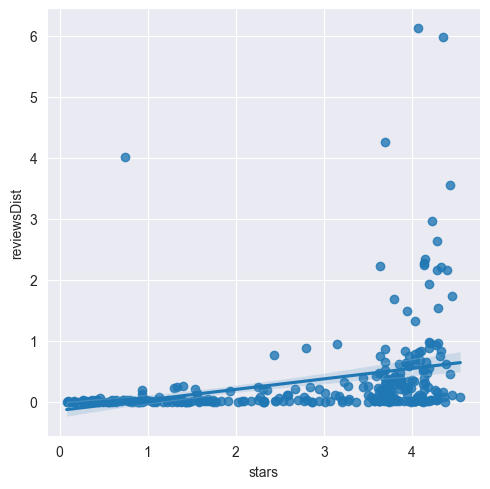

In [25]:
sns.lmplot(data=agg_categories, x='stars', y='reviewsDist')

In [26]:
conds = np.array([
    [
        (df["price"] <= 80),
        ((df["price"] > 80) & (df["price"] <= 200)),
        (df["price"] > 200),
    ], [
        (df["reviews"] <= 500),
        ((df["reviews"] > 500) & (df["reviews"] <= 2000)),
        (df["reviews"] > 2000)
    ]])
vals = np.array([
    [
        "Low Price",
        "Mid Price",
        "High Price"
    ], [
        "Low Engagement",
        "Moderate Engagement",
        "High Engagement"
    ]])

s1 = pd.Series(np.select(conds[0], vals[0], "Unknown Range"))
s2 = pd.Series(np.select(conds[1], vals[1], "Unknown Range"))

cond = [
    ((s1 == "Low Price") & (s2 == "Low Engagement")),
    ((s1 == "Low Price") & (s2 == "Moderate Engagement")),
    ((s1 == "Low Price") & (s2 == "High Engagement")),
    ((s1 == "Mid Price") & (s2 == "Low Engagement")),
    ((s1 == "Mid Price") & (s2 == "Moderate Engagement")),
    ((s1 == "Mid Price") & (s2 == "High Engagement")),
    ((s1 == "High Price") & (s2 == "Low Engagement")),
    ((s1 == "High Price") & (s2 == "Moderate Engagement")),
    ((s1 == "High Price") & (s2 == "High Engagement")),
    ]
val = [
    "Low-Low",
    "Low-Moderate",
    "Low-High",
    "Mid-Low",
    "Mid-Moderate",
    "Mid-High",
    "High-Low",
    "High-Moderate",
    "High-High"
]

categories_segments = pd.concat([
                        df["categoryName"],
                        pd.Series(np.select(cond, val, "Unknown"))
                    ],
                    axis=1
                    ).rename(columns={"categoryName": "Category", 0: "Price-Engagement Level"})
categories_segments


,Category,Price-Engagement Level
0,Hi-Fi Speakers,Low-High
1,Hi-Fi Speakers,Low-High
2,Hi-Fi Speakers,Low-High
3,Hi-Fi Speakers,Low-High
4,Hi-Fi Speakers,Low-Moderate
...,...,...
2187856,Motorbike Clothing,Low-Low
2187857,Motorbike Clothing,Mid-Low
2187858,Motorbike Clothing,Low-Low
2187859,Motorbike Clothing,Low-Low


In [27]:
agg_categories_segments = (categories_segments
    .groupby(["Category", "Price-Engagement Level"])
    .agg(Price_Engagement_Level_Count = ("Price-Engagement Level", "count"))
    .reset_index()
    .rename(columns={"Price_Engagement_Level_Count": "Price-Engagement Level Count"})
)
agg_categories_segments.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_11460\1903140848.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["Category", "Price-Engagement Level"])


,Category,Price-Engagement Level,Price-Engagement Level Count
0,3D Printers,High-High,2
1,3D Printers,High-Low,153
2,3D Printers,High-Moderate,8
3,3D Printers,Low-High,1
4,3D Printers,Low-Low,21


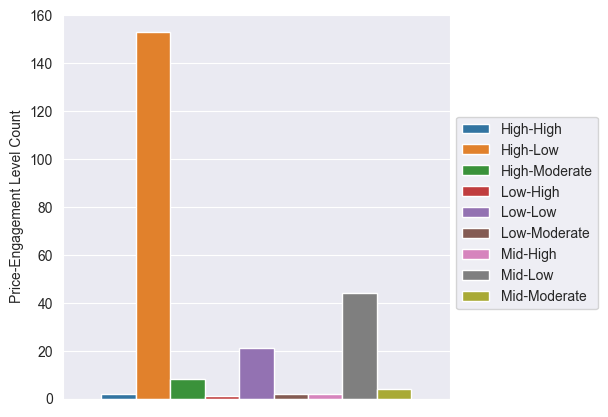

In [ ]:
# Sample Plot
plt.figure(figsize=(5, 5))
sns.barplot(
    data=agg_categories_segments.loc[agg_categories_segments["Category"] == "3D Printers", :], 
    y="Price-Engagement Level Count", 
    hue="Price-Engagement Level"
)
plt.legend(bbox_to_anchor=(1.4,0.75))

### Product Ranking
- Unified Scoring Model
- Find best products based on:
    - Stars
    - Reviews
    - Price-To-Value Ratio

In [56]:
stars_weight = (0.0004 * (df.sort_values("stars", ascending=True, ignore_index=True).index + 1)).round(0)
review_weight = (0.0004 * (df.sort_values("reviews", ascending=True, ignore_index=True).index + 1)).round(0)
price_to_value_weight = (0.0002 * ((df["price"] / df["stars"]).sort_values(ascending=True, ignore_index=True).index + 1)).round(0)

scoring_model = ((pd.concat([
                    df["asin"],
                    pd.Series(stars_weight, name="stars_weight"),
                    pd.Series(review_weight, name="review_weight"),
                    pd.Series(price_to_value_weight, name="price-to-value_weight")
                ],
                axis=1)
                ).assign(
                    overall_score= lambda x: x["stars_weight"] + x["review_weight"] + x["price-to-value_weight"]
                ).sort_values("overall_score", ascending=False, ignore_index=True)
                )

scoring_model.head()

,asin,stars_weight,review_weight,price-to-value_weight,overall_score
0,B0B6WMBC35,875.0,875.0,438.0,2188.0
1,B08MF8WDF3,875.0,875.0,438.0,2188.0
2,B0C34G8PDW,875.0,875.0,438.0,2188.0
3,B08WKKC6WX,875.0,875.0,438.0,2188.0
4,B08MVXBT8Q,875.0,875.0,438.0,2188.0


In [68]:
scoring_model.loc[:, ["asin", "stars_weight"]].sort_values("stars_weight", ascending=False, ignore_index=True)

,asin,stars_weight
0,B0C34G8PDW,875.0
1,B07Z3QVMT6,875.0
2,B09XV9T4CJ,875.0
3,B01MA2B6MY,875.0
4,B0BW3TKYJS,875.0
...,...,...
2187856,B0BRCDTN9Q,0.0
2187857,B00PUH6RXM,0.0
2187858,B0BF61ZLC9,0.0
2187859,B08VDJ888B,0.0


In [69]:
scoring_model.loc[:, ["asin", "review_weight"]].sort_values("review_weight", ascending=False, ignore_index=True)

,asin,review_weight
0,B0C34G8PDW,875.0
1,B07Z3QVMT6,875.0
2,B09XV9T4CJ,875.0
3,B01MA2B6MY,875.0
4,B0BW3TKYJS,875.0
...,...,...
2187856,B0BRCDTN9Q,0.0
2187857,B00PUH6RXM,0.0
2187858,B0BF61ZLC9,0.0
2187859,B08VDJ888B,0.0


In [70]:
scoring_model.loc[:, ["asin", "price-to-value_weight"]].sort_values("price-to-value_weight", ascending=False, ignore_index=True)

,asin,price-to-value_weight
0,B08MF8WDF3,438.0
1,B09G2Y5FPP,438.0
2,B0BPBYX8TD,438.0
3,B09TWH424G,438.0
4,B07JM93SCC,438.0
...,...,...
2187856,B09B8XRZYB,0.0
2187857,B09B2SS2G1,0.0
2187858,B0BRCDTN9Q,0.0
2187859,B00PUH6RXM,0.0


### 6. Price Optimization
- Identify underpriced or overpriced products
- Count overpriced & underpriced products by category
- Compute the correlation between price, reviews, and stars to quantify the strength of the relationship
- Identify price ranges that maximize reviews
- Identify price ranges that maximize stars

In [82]:
price_range = {"min": df["price"].min(), "max": df["price"].max(), "avg": df["price"].mean().round(2), "median": df["price"].median()}
print(f"Min: ${price_range["min"]}\nMax: ${price_range["max"]}\nAvg: ${price_range["avg"]}\nMedian: ${price_range["median"]}")

Min: $0.0
Max: $6083.58
Avg: $69.46
Median: $19.31


In [84]:
overpriced_underprice_products = df.loc[(df["price"] <= price_range["avg"] * 0.5) | (df["price"] >= price_range["avg"] * price_range["median"]), ["asin", "categoryName", "price"]]
overpriced_underprice_products

,asin,categoryName,price
0,B09B96TG33,Hi-Fi Speakers,21.99
1,B01HTH3C8S,Hi-Fi Speakers,23.99
2,B09B8YWXDF,Hi-Fi Speakers,21.99
3,B09B8T5VGV,Hi-Fi Speakers,31.99
4,B09WX6QD65,Hi-Fi Speakers,17.99
...,...,...,...
2187845,B0BHQZBSJD,Motorbike Clothing,14.49
2187850,B0BX2KM9KQ,Motorbike Clothing,10.99
2187854,B07X98JLFF,Motorbike Clothing,14.99
2187855,B0BQMXJPP5,Motorbike Clothing,19.99


In [86]:
(overpriced_underprice_products
 .groupby("categoryName", as_index=False)
 .agg(outlier_products_count= ("asin", "count"))
)

C:\Users\hp\AppData\Local\Temp\ipykernel_11460\2737621481.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("categoryName", as_index=False)


,categoryName,outlier_products_count
0,3D Printers,50
1,3D Printing & Scanning,1915
2,Abrasive & Finishing Products,235
3,Action Cameras,274
4,Adapters,247
...,...,...
291,Wind Instruments,113
292,Window Treatments,219
293,Women,14130
294,Women's Sports & Outdoor Shoes,507


In [91]:
corr_table = df.loc[:, ["price", "reviews", "stars"]].corr()
corr_table

,price,reviews,stars
price,1.000000,-0.015317,-0.141480
reviews,-0.015317,1.000000,0.084914
stars,-0.141480,0.084914,1.000000


<Axes: >

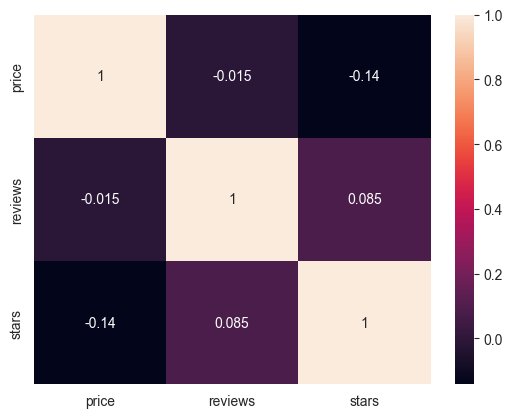

In [92]:

sns.heatmap(corr_table, annot=True)

In [94]:
max_reviews = df.loc[df["reviews"] == df["reviews"].max(), ["asin", "price"]]
price_range = {"min": max_reviews["price"].min(), "max": max_reviews["price"].max(), "avg": max_reviews["price"].mean().round(2), "median": max_reviews["price"].median().round(2)}
print(f"Min: ${price_range["min"]}\nMax: ${price_range["max"]}\nAvg: ${price_range["avg"]}\nMedian: ${price_range["median"]}")

Min: $5.19
Max: $25.92
Avg: $10.96
Median: $8.38


In [95]:
max_stars = df.loc[df["stars"] == df["stars"].max(), ["asin", "price"]]
price_range = {"min": max_stars["price"].min(), "max": max_stars["price"].max(), "avg": max_stars["price"].mean().round(2), "median": max_stars["price"].median().round(2)}
print(f"Min: ${price_range["min"]}\nMax: ${price_range["max"]}\nAvg: ${price_range["avg"]}\nMedian: ${price_range["median"]}")

Min: $0.0
Max: $3999.0
Avg: $54.87
Median: $18.92
